<a href="https://colab.research.google.com/github/pedromperezc/CEIA/blob/master/AP/Defafio_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyección de ventas de bebidas alcoholicas 1 año a futuro

fuente: https://www.kaggle.com/namanmanchanda/rnn-in-pytorch/notebook

datos: https://www.kaggle.com/bulentsiyah/for-simple-exercises-time-series-forecasting/version/6

fuente original datos: https://fred.stlouisfed.org/series/S4248SM144NCEN



In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/DEEP_LEARNING/Alcohol_Sales.csv", index_col = 0, parse_dates = True)
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [4]:
df.dropna(inplace=True)
len(df)

325

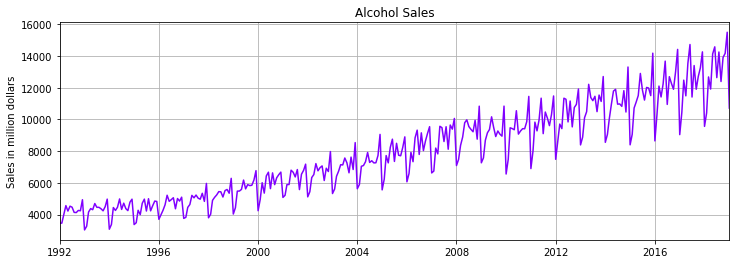

In [5]:
# visualización de datos
plt.figure(figsize = (12,4))
plt.title('Alcohol Sales')
plt.ylabel('Sales in million dollars')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'],color='#8000ff')
plt.show()

In [6]:
# extracting the time series values
y = df['S4248SM144NCEN'].values.astype(float) 

#defining a test size (los últimos 12 meses para el test final)
test_size = 24

#create train and test splits
train_set = y[:-test_size]
test_set = y[-test_size:]

print(len(test_set))


24


In [7]:
# normalización de datos
from sklearn.preprocessing import MinMaxScaler

# instantiate a scaler
scaler = MinMaxScaler(feature_range=(-1, 1))

# normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))


In [8]:
# convert train_norm to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# define a window size
# aca se define el número de muestras que se utilizan para predecir (como entrada)
# cuantos datos del pasado tomo como referencia para estimar el siguiente
window_size = 3

# define a function to create sequence/label tuples
def input_data(seq, ws):
    out = []
    L = len(seq)
    for i in range(L-ws): 
        window = seq[i:i+ws]# barro el 'seq' desde el inicio, con un largo de ws
        label = seq[i+ws:i+ws+1] # saco el 'label' siguiente, correspondiente al valor del siguiente año
        out.append((window,label)) # unifico en una list los inputs y el label
    return out

# apply input_data to train_norm
train_data = input_data(train_norm, window_size)
print('número de datos para entrenar [input, label]: ', len(train_data))
print('por ejemplo, el primero: ')
print(train_data[0])


número de datos para entrenar [input, label]:  298
por ejemplo, el primero: 
(tensor([-0.9248, -0.9250, -0.8295]), tensor([-0.7308]))


Defino mi RNN con LSTM

In [224]:
class LSTMnetwork(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # initializing h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]


In [214]:
def train_model(window_size, hideen, epochs, model):

  # loss
  criterion = nn.MSELoss()
  #optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  print ("modelo input_size="+ str(window_size) + " hidden_size=" +str(hideen))

  import time
  start_time = time.time()

  lista_loss = []
  train_data = input_data(train_norm, window_size)

  for epoch in range(epochs):
      for seq, y_train in train_data:
          optimizer.zero_grad()
          
          model.hidden = (torch.zeros(1,1,model.hidden_size),
                          torch.zeros(1,1,model.hidden_size))
          
          y_pred = model(seq)
          
          loss = criterion(y_pred, y_train)
          loss.backward()
          optimizer.step()
          
      # print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
      lista_loss.append(loss.item())
  print(f'\nDuration: {time.time() - start_time:.0f} seconds')
  plt.figure(figsize=(12,4))
  plt.title('loss')
  plt.plot(lista_loss, color='#8000ff')

  future = 12 # para fijar cuantos datos a futuro voy a iterar

  # tomo los últimos window_size meses, acorde al entrenamiento del modelo
  preds = train_norm[-window_size:].tolist()
  print('largo input: ', len(preds))


  model.eval()
  # armo for loop para ir agregando la última predicción y la uso para predecir el futuro
  for i in range(future):
      seq = torch.FloatTensor(preds[-window_size:])
      with torch.no_grad():
          model.hidden = (torch.zeros(1,1,model.hidden_size),
                          torch.zeros(1,1,model.hidden_size))
          salida = model(seq).item()
          preds.append(salida) # acá estoy cargando la última predicción

  true_predictions = scaler.inverse_transform(np.array(preds[-future:]).reshape(-1, 1))

  print('largo últimos predecidos: ', len(preds[-future:]))

  # calculo de error de lo predecido vs el último mes no usado en el entrenamiento
  pred_f = torch.FloatTensor(true_predictions)
  test_norm = df['S4248SM144NCEN'][-12:].to_numpy()
  test_norm = torch.FloatTensor(test_norm)
  loss = criterion(pred_f.squeeze(), test_norm.squeeze())
  print('MSE : ', torch.sqrt(loss).item())

  fig = plt.figure(figsize=(12,4))
  plt.title('Alcohol Sales')
  plt.ylabel('Sales in million dollars')
  plt.grid(True)
  plt.autoscale(axis='x',tight=True)
  fig.autofmt_xdate()

  x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')

  plt.plot(df['S4248SM144NCEN']['2016-01-01':], color='#8000ff')
  plt.plot(x,true_predictions, color='#ff8000')
  plt.show()

modelo input_size=3 hidden_size=50

Duration: 78 seconds
largo input:  3
largo últimos predecidos:  12
MSE :  1761.6075439453125


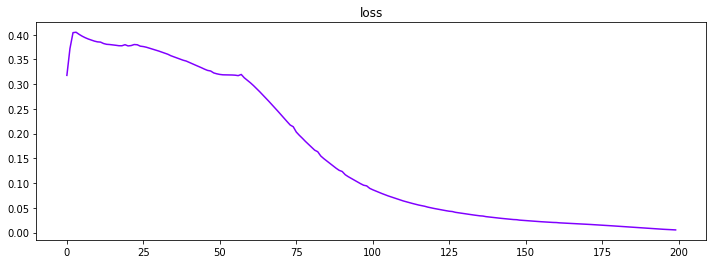

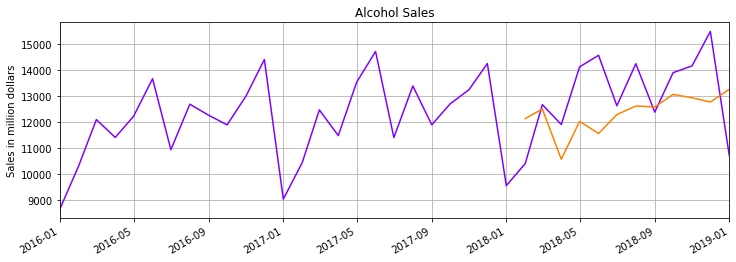

In [23]:
imput = 3
hideen = 50
epoch = 200
model = LSTMnetwork(input_size=1, hidden_size=hideen,  output_size=1)

train_model(imput, hideen, epoch, model)

modelo input_size=3 hidden_size=100

Duration: 91 seconds
largo input:  3
largo últimos predecidos:  12
MSE :  3428.12646484375


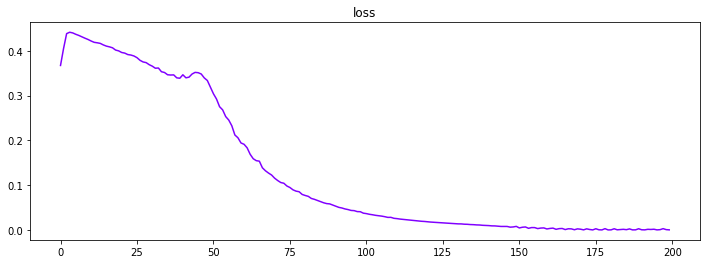

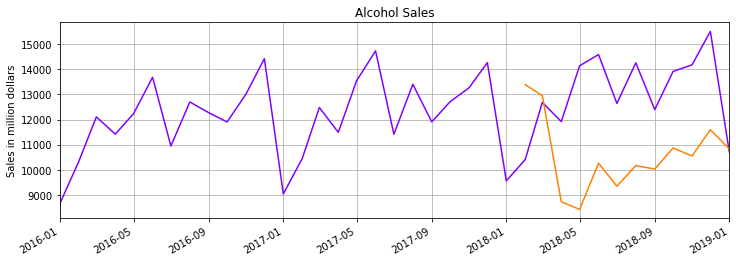

In [20]:
imput = 3
hideen = 100
epoch = 200
model = LSTMnetwork(input_size=1, hidden_size=hideen,  output_size=1)

train_model(imput, hideen, epoch, model)

modelo input_size=3 hidden_size=150

Duration: 126 seconds
largo input:  3
largo últimos predecidos:  12
MSE :  2873.298095703125


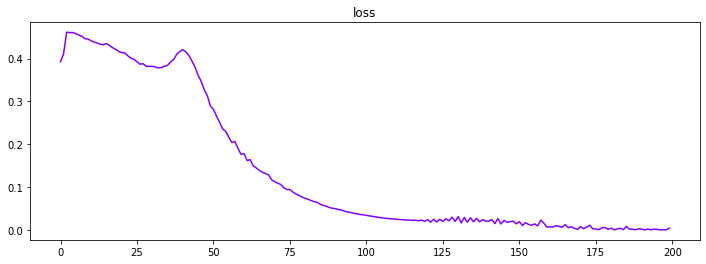

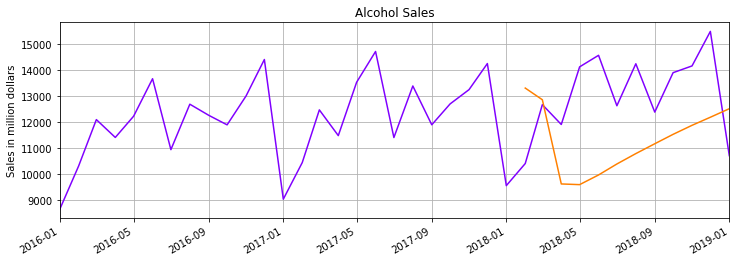

In [22]:
imput = 3
hideen = 150
epoch = 200
model = LSTMnetwork(input_size=1, hidden_size=hideen,  output_size=1)

train_model(imput, hideen, epoch, model)

modelo input_size=3 hidden_size=200

Duration: 162 seconds
largo input:  3
largo últimos predecidos:  12
MSE :  1884.4010009765625


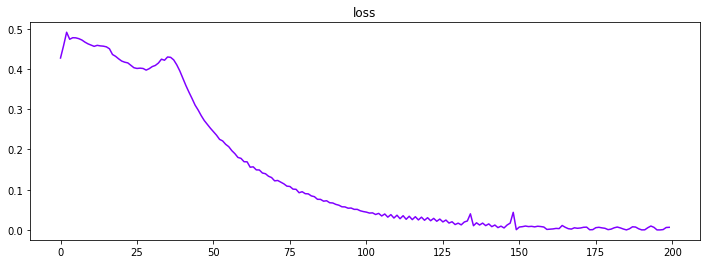

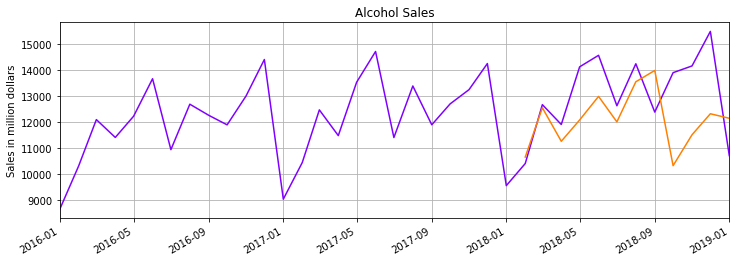

In [24]:
imput = 3
hideen = 200
epoch = 200
model = LSTMnetwork(input_size=1, hidden_size=hideen,  output_size=1)

train_model(imput, hideen, epoch, model)

modelo input_size=6 hidden_size=50

Duration: 53 seconds
largo input:  6
largo últimos predecidos:  12
MSE :  1278.7467041015625


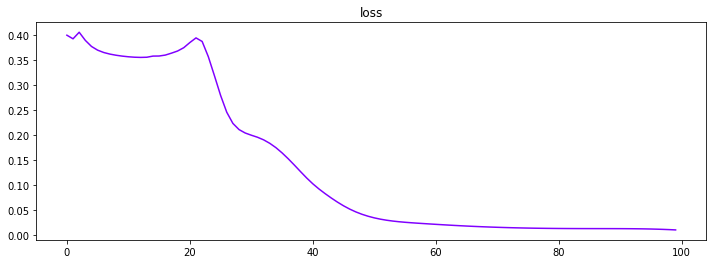

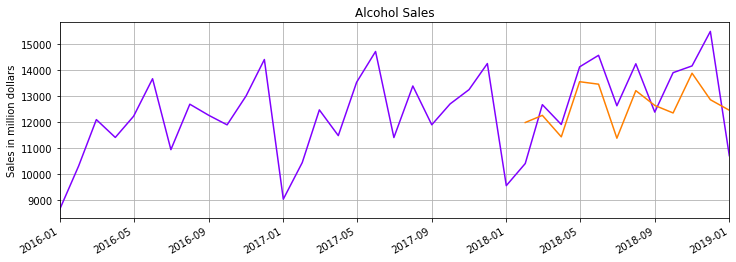

In [51]:
imput = 6
hideen = 50
epoch = 100
model = LSTMnetwork(input_size=1, hidden_size=hideen,  output_size=1)

train_model(imput, hideen, epoch, model)

modelo input_size=6 hidden_size=100

Duration: 60 seconds
largo input:  6
largo últimos predecidos:  12
MSE :  2420.2890625


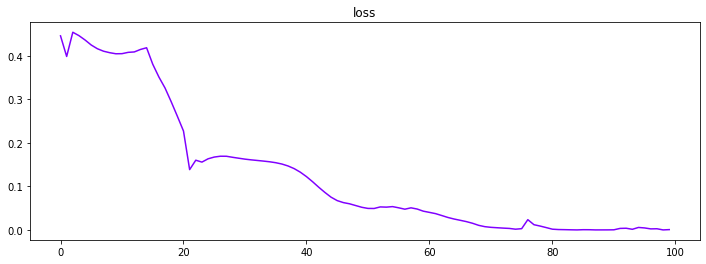

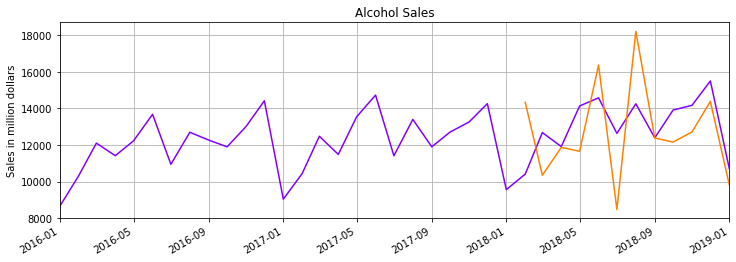

In [52]:
imput = 6
hideen = 100
epoch = 100
model = LSTMnetwork(input_size=1, hidden_size=hideen,  output_size=1)

train_model(imput, hideen, epoch, model)

modelo input_size=6 hidden_size=150

Duration: 92 seconds
largo input:  6
largo últimos predecidos:  12
MSE :  1535.29736328125


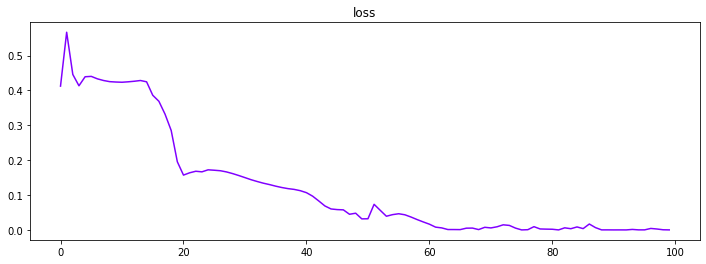

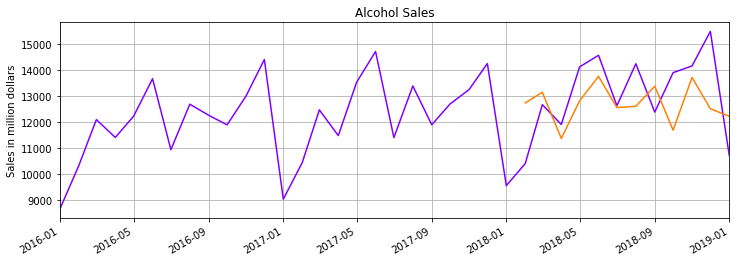

In [53]:
imput = 6
hideen = 150
epoch = 100
model = LSTMnetwork(input_size=1, hidden_size=hideen,  output_size=1)

train_model(imput, hideen, epoch, model)

modelo input_size=6 hidden_size=200

Duration: 124 seconds
largo input:  6
largo últimos predecidos:  12
MSE :  2409.084716796875


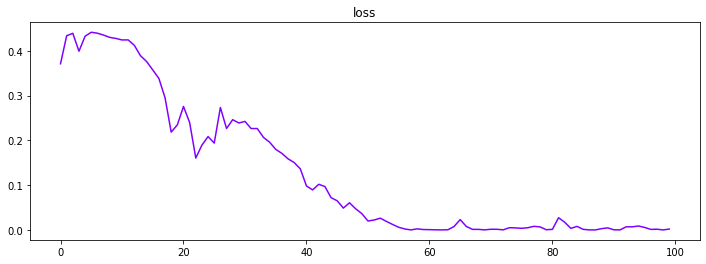

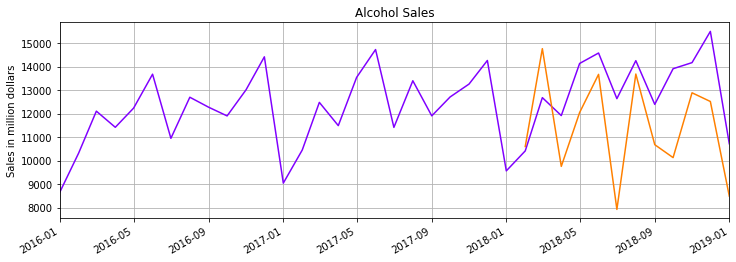

In [54]:
imput = 6
hideen = 200
epoch = 100
model = LSTMnetwork(input_size=1, hidden_size=hideen,  output_size=1)

train_model(imput, hideen, epoch, model)

modelo input_size=9 hidden_size=50

Duration: 37 seconds
largo input:  9
largo últimos predecidos:  12
MSE :  1461.412109375


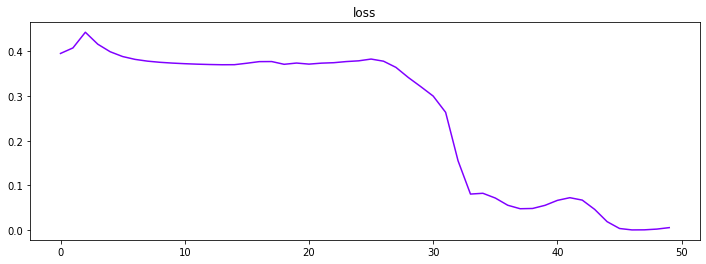

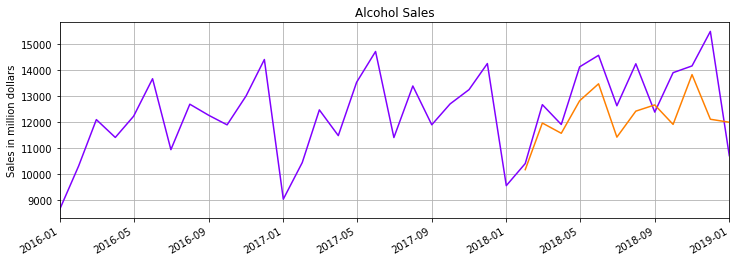

In [56]:
imput = 9
hideen = 50
epoch = 50
model = LSTMnetwork(input_size=1, hidden_size=hideen,  output_size=1)

train_model(imput, hideen, epoch, model)

modelo input_size=9 hidden_size=100

Duration: 35 seconds
largo input:  9
largo últimos predecidos:  12
MSE :  1177.35791015625


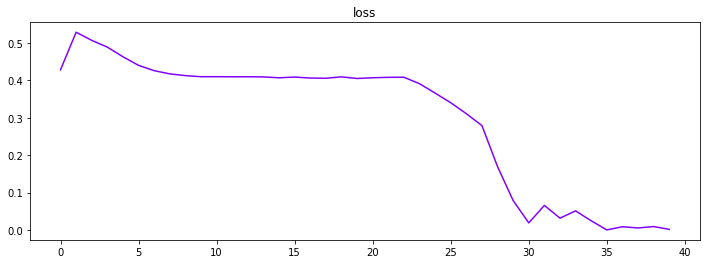

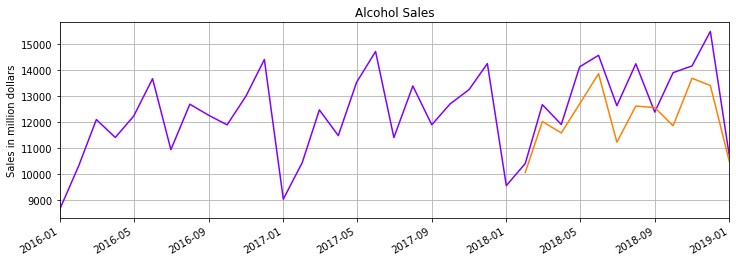

In [46]:
imput = 9
hideen = 100
epoch = 40
model = LSTMnetwork(input_size=1, hidden_size=hideen,  output_size=1)

train_model(imput, hideen, epoch, model)

modelo input_size=9 hidden_size=150

Duration: 52 seconds
largo input:  9
largo últimos predecidos:  12
MSE :  1233.63720703125


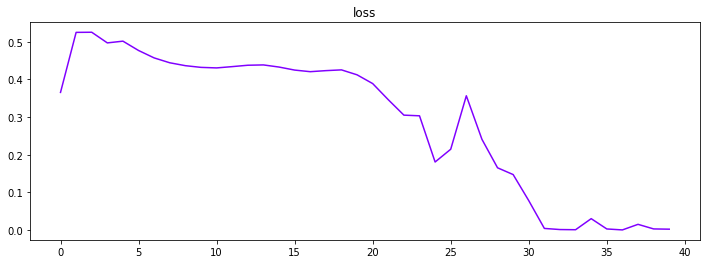

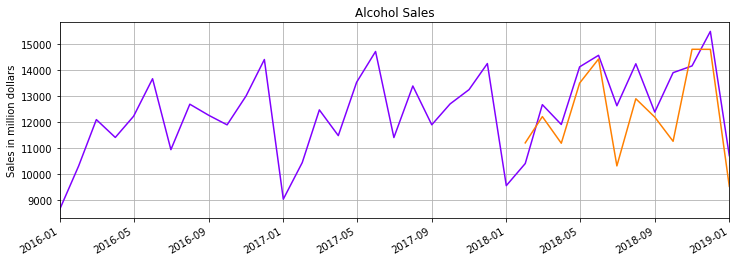

In [50]:
imput = 9
hideen = 150
epoch = 40
model = LSTMnetwork(input_size=1, hidden_size=hideen,  output_size=1)

train_model(imput, hideen, epoch, model)

modelo input_size=9 hidden_size=150

Duration: 63 seconds
largo input:  9
largo últimos predecidos:  12
MSE :  1136.86376953125


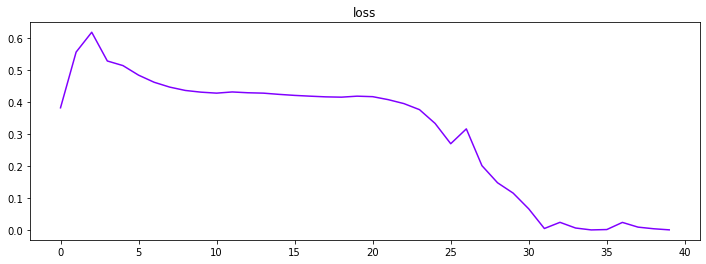

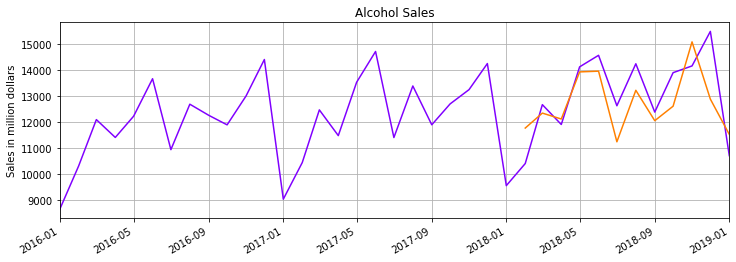

In [49]:
imput = 9
hideen = 150
epoch = 40
model = LSTMnetwork(input_size=1, hidden_size=hideen,  output_size=1)

train_model(imput, hideen, epoch, model)

modelo input_size=9 hidden_size=200

Duration: 73 seconds
largo input:  9
largo últimos predecidos:  12
MSE :  2144.984375


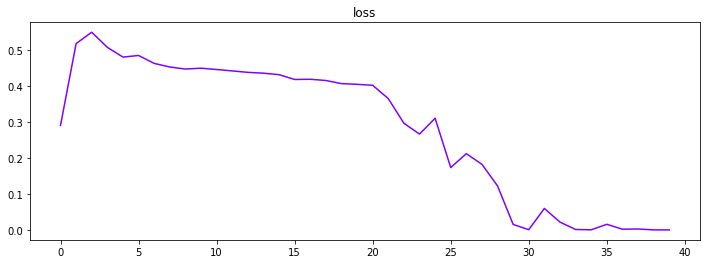

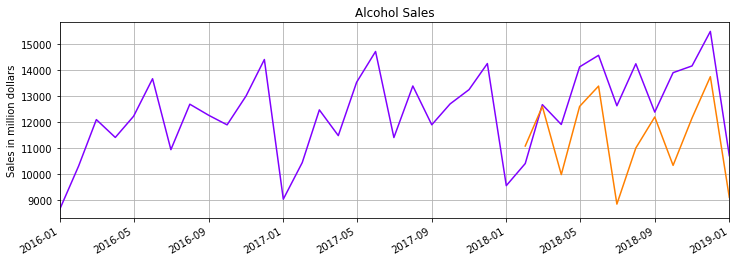

In [57]:
imput = 9
hideen = 200
epoch = 40
model = LSTMnetwork(input_size=1, hidden_size=hideen,  output_size=1)

train_model(imput, hideen, epoch, model)

modelo input_size=12 hidden_size=50

Duration: 28 seconds
largo input:  12
largo últimos predecidos:  12
MSE :  991.2124633789062


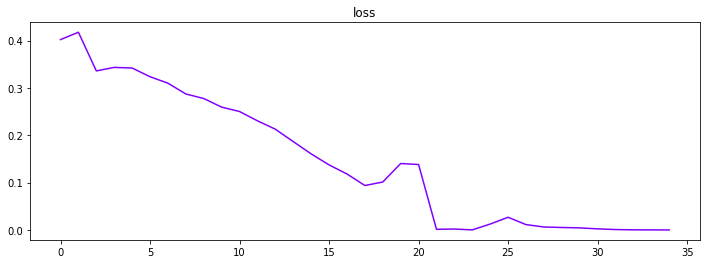

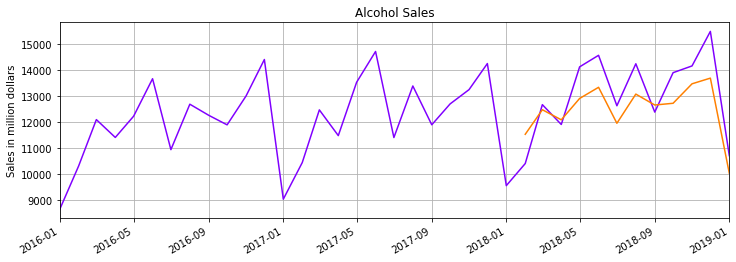

In [64]:
imput = 12
hideen = 50
epoch = 35
model = LSTMnetwork(input_size=1, hidden_size=hideen,  output_size=1)

train_model(imput, hideen, epoch, model)

modelo input_size=12 hidden_size=100

Duration: 34 seconds
largo input:  12
largo últimos predecidos:  12
MSE :  871.3060913085938


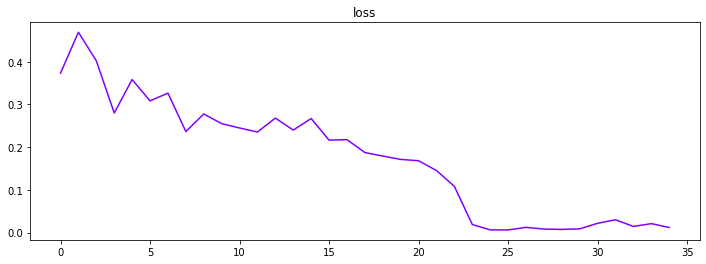

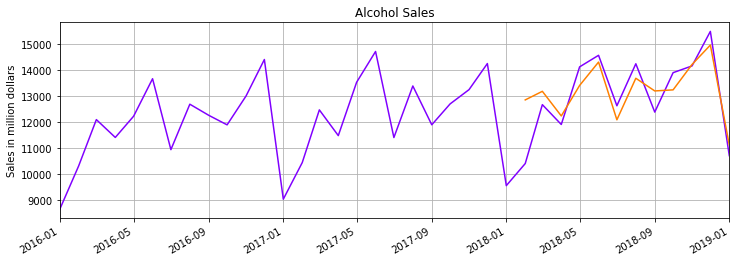

In [67]:
imput = 12
hideen = 100
epoch = 35
model = LSTMnetwork(input_size=1, hidden_size=hideen,  output_size=1)

train_model(imput, hideen, epoch, model)

modelo input_size=12 hidden_size=150

Duration: 81 seconds
largo input:  12
largo últimos predecidos:  12
MSE :  1100.9842529296875


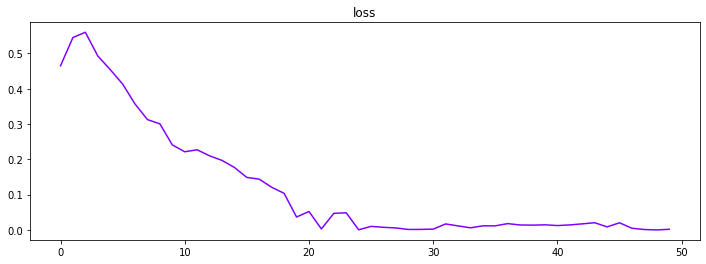

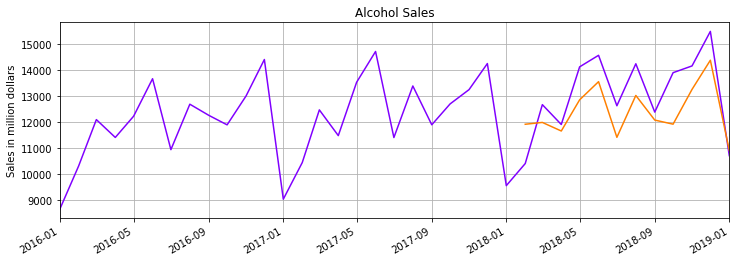

In [71]:
imput = 12
hideen = 150
epoch = 50
model = LSTMnetwork(input_size=1, hidden_size=hideen,  output_size=1)

train_model(imput, hideen, epoch, model)

modelo input_size=12 hidden_size=200

Duration: 101 seconds
largo input:  12
largo últimos predecidos:  12
MSE :  847.0736694335938


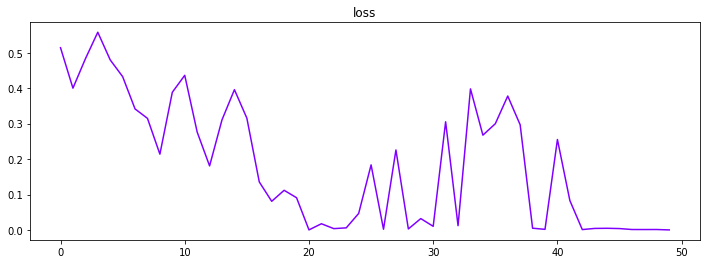

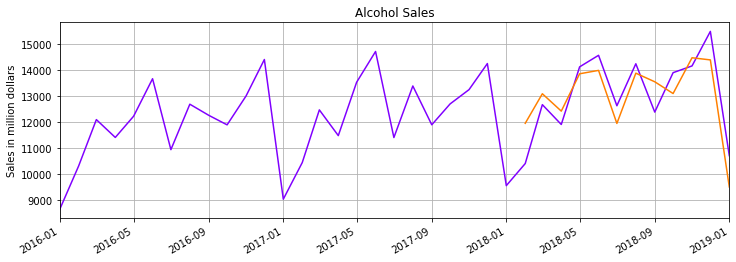

In [72]:
imput = 12
hideen = 200
epoch = 50
model = LSTMnetwork(input_size=1, hidden_size=hideen,  output_size=1)

train_model(imput, hideen, epoch, model)

modelo input_size=18 hidden_size=50

Duration: 101 seconds
largo input:  18
largo últimos predecidos:  12
MSE :  2011.2794189453125


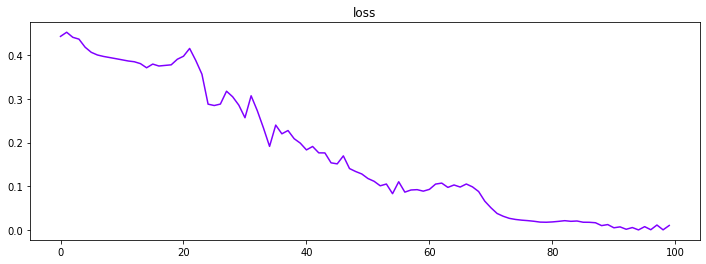

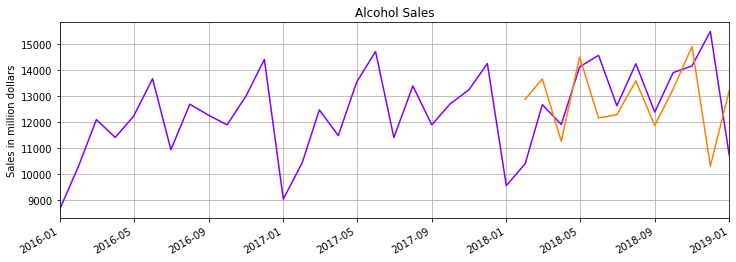

In [75]:
imput = 18
hideen = 50
epoch = 100
model = LSTMnetwork(input_size=1, hidden_size=hideen,  output_size=1)

train_model(imput, hideen, epoch, model)

modelo input_size=18 hidden_size=100

Duration: 72 seconds
largo input:  18
largo últimos predecidos:  12
MSE :  1027.4449462890625


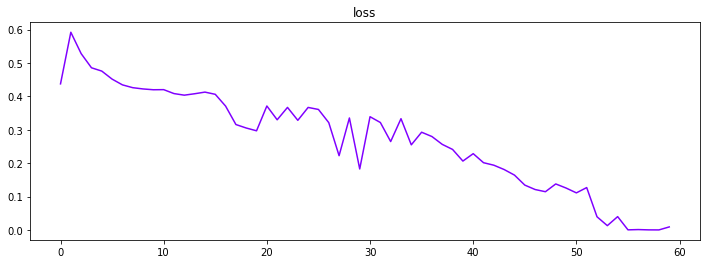

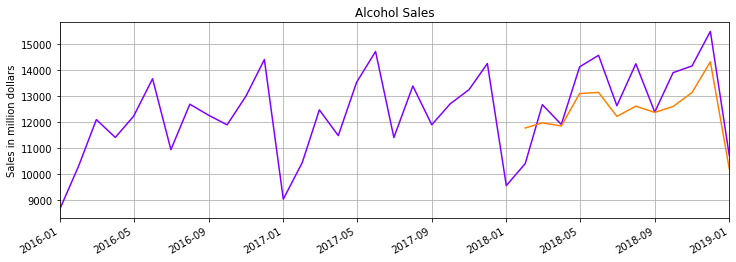

In [77]:
imput = 18
hideen = 100
epoch = 60
model = LSTMnetwork(input_size=1, hidden_size=hideen,  output_size=1)

train_model(imput, hideen, epoch, model)

modelo input_size=18 hidden_size=150

Duration: 121 seconds
largo input:  18
largo últimos predecidos:  12
MSE :  1795.662841796875


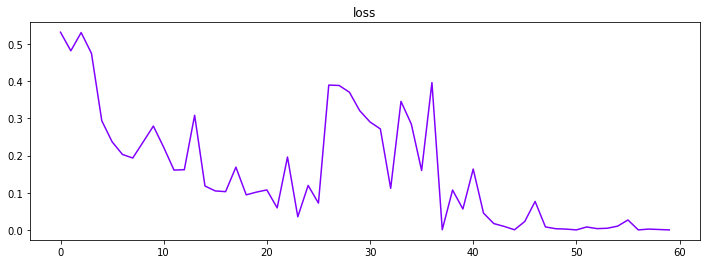

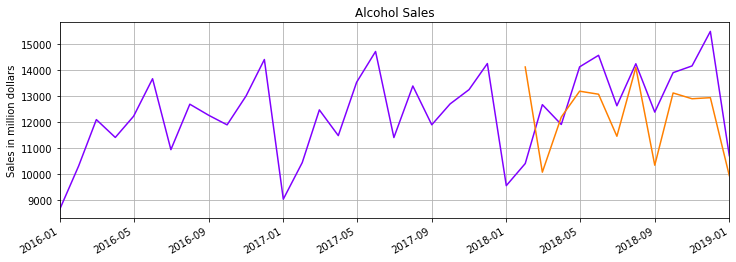

In [78]:
imput = 18
hideen = 150
epoch = 60
model = LSTMnetwork(input_size=1, hidden_size=hideen,  output_size=1)

train_model(imput, hideen, epoch, model)

modelo input_size=18 hidden_size=200

Duration: 137 seconds
largo input:  18
largo últimos predecidos:  12
MSE :  1511.892578125


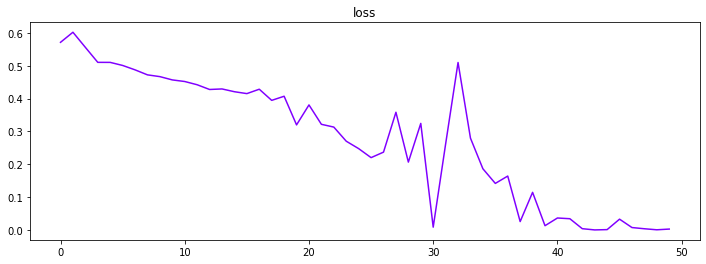

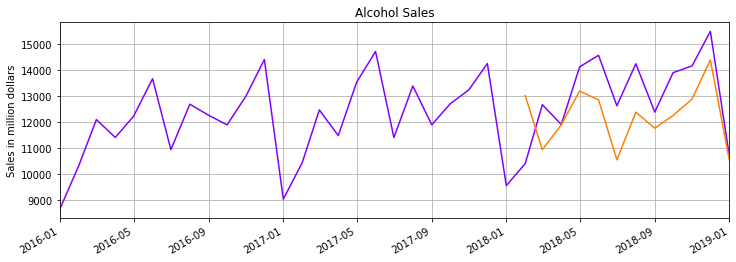

In [82]:
imput = 18
hideen = 200
epoch = 50
model = LSTMnetwork(input_size=1, hidden_size=hideen,  output_size=1)

train_model(imput, hideen, epoch, model)

modelo input_size=24 hidden_size=50

Duration: 133 seconds
largo input:  24
largo últimos predecidos:  12
MSE :  1429.0999755859375


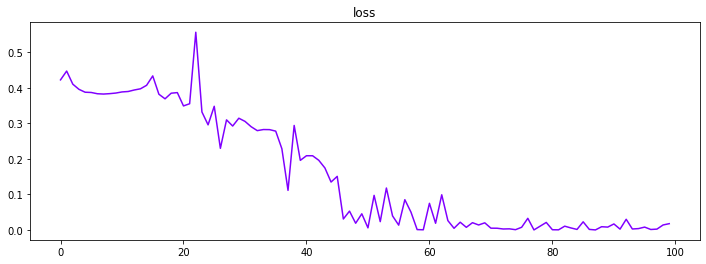

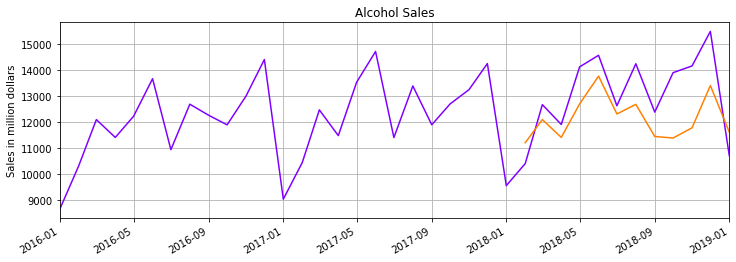

In [85]:
imput = 24
hideen = 50
epoch = 100
model = LSTMnetwork(input_size=1, hidden_size=hideen,  output_size=1)

train_model(imput, hideen, epoch, model)

modelo input_size=24 hidden_size=100

Duration: 145 seconds
largo input:  24
largo últimos predecidos:  12
MSE :  1553.1671142578125


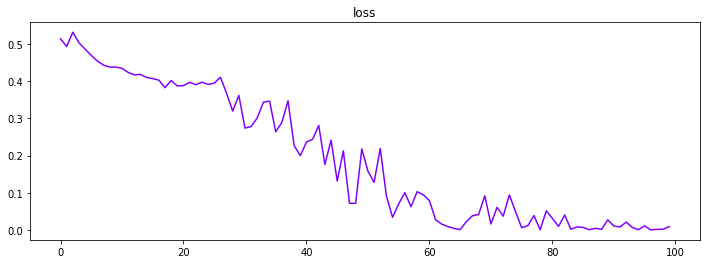

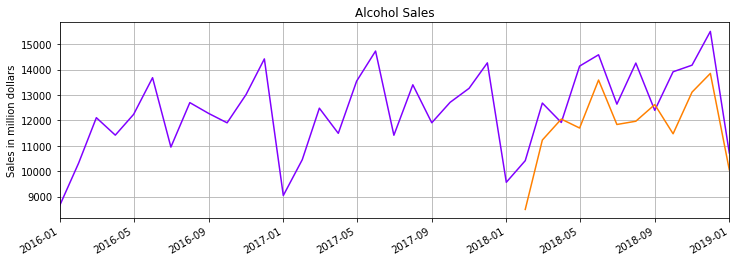

In [86]:
imput = 24
hideen = 100
epoch = 100
model = LSTMnetwork(input_size=1, hidden_size=hideen,  output_size=1)

train_model(imput, hideen, epoch, model)

modelo input_size=24 hidden_size=150

Duration: 263 seconds
largo input:  24
largo últimos predecidos:  12
MSE :  2429.149658203125


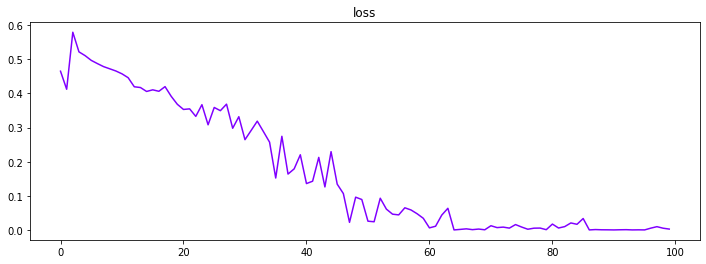

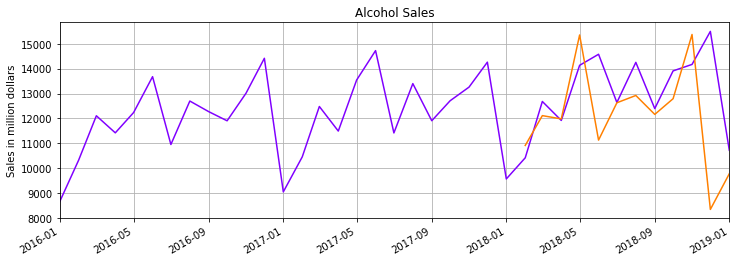

In [87]:
imput = 24
hideen = 150
epoch = 100
model = LSTMnetwork(input_size=1, hidden_size=hideen,  output_size=1)

train_model(imput, hideen, epoch, model)

modelo input_size=24 hidden_size=200

Duration: 184 seconds
largo input:  24
largo últimos predecidos:  12
MSE :  866.1289672851562


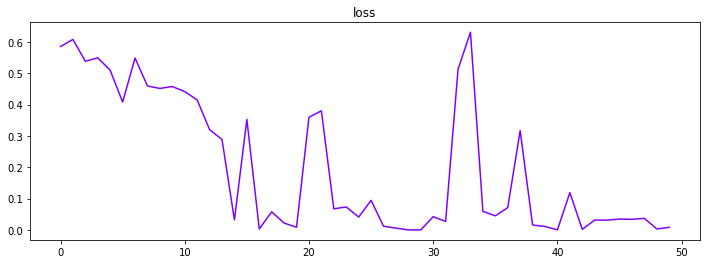

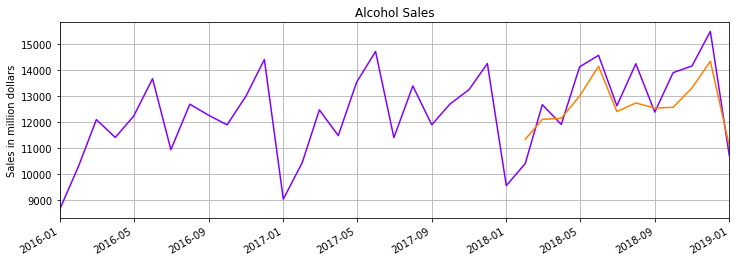

In [89]:
imput = 24
hideen = 200
epoch = 50
model = LSTMnetwork(input_size=1, hidden_size=hideen,  output_size=1)

train_model(imput, hideen, epoch, model)

# MEJOR MODELO

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


modelo input_size=12 hidden_size=100

Duration: 37 seconds
largo input:  12
largo últimos predecidos:  12
MSE :  1422.04296875


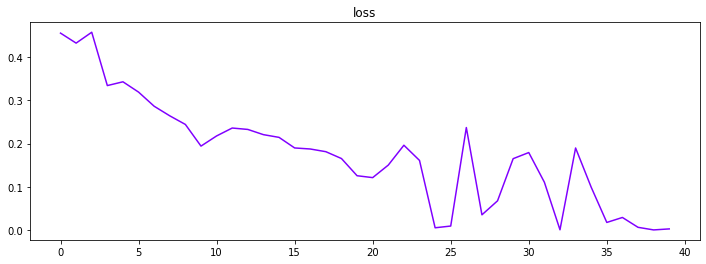

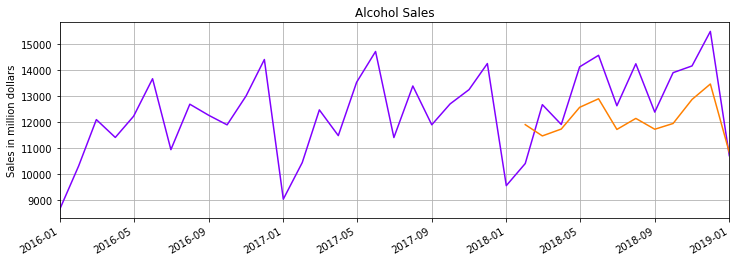

In [226]:
imput = 12
hideen = 100
epoch = 40
model = LSTMnetwork(input_size=1, hidden_size=hideen,  output_size=1)

train_model(imput, hideen, epoch, model)

# CONCLUSIONES:

-	A medida que se incrementa el tamaño del input de la red, el modelo mejora y es posible obtener mejores predicciones.
-	Llega un punto en la cual no se mejora el modelo por más que se incrementa el tamaño del input.
-	Cuando se incrementa el número de hidden unit se incrementa el número de parámetros, por lo tanto, el tiempo de entrenamiento es más lento.
-	Cuando se incrementa el número de hidden unit se logra un mejor modelo.
